In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import itertools
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.plot import plot_plotly

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("store_sales_data_clean_20240214.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9800 non-null   int64  
 1   Order Date    9800 non-null   object 
 2   Segment       9800 non-null   object 
 3   Region        9800 non-null   object 
 4   Category      9800 non-null   object 
 5   Sub-Category  9800 non-null   object 
 6   Sales         9800 non-null   float64
 7   Day of Week   9800 non-null   int64  
 8   Day           9800 non-null   int64  
 9   Year          9800 non-null   int64  
 10  Month         9800 non-null   int64  
 11  Season        9800 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 918.9+ KB


In [4]:
df.head()

,Unnamed: 0,Order Date,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
0,0,2017-11-08,Consumer,South,Furniture,Bookcases,261.9600,2,8,2017,11,Autumn
1,1,2017-11-08,Consumer,South,Furniture,Chairs,731.9400,2,8,2017,11,Autumn
2,2,2017-06-12,Corporate,West,Office Supplies,Labels,14.6200,0,12,2017,6,Summer
3,3,2016-10-11,Consumer,South,Furniture,Tables,957.5775,1,11,2016,10,Autumn
4,4,2016-10-11,Consumer,South,Office Supplies,Storage,22.3680,1,11,2016,10,Autumn


In [5]:
# Group sales data by day, sort by Order Date
df_grouped = df.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()
df_grouped = df_grouped.sort_values(by='Order Date', ascending=True)
df_grouped['Order Date'] = pd.to_datetime(df_grouped['Order Date'])



In [6]:
is_one_day_apart = (df_grouped['Order Date'].diff().dt.days == 1).all()

# Print the result
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [7]:
# Set the 'Order Date' column as the index
df_grouped = df_grouped.set_index('Order Date')

# Create a new DataFrame with a daily frequency
daily_index = pd.date_range(start=df_grouped.index.min(), end=df_grouped.index.max(), freq='D')
df_daily = pd.DataFrame(index=daily_index)

# Merge the original DataFrame with the new DataFrame, filling missing values with 0
df_merged = df_daily.merge(df_grouped, how='left', left_index=True, right_index=True).fillna(0)

# Reset the index
df_merged = df_merged.reset_index()

# Rename the columns
df_merged = df_merged.rename(columns={'index': 'Order Date'})

# Print the result
print(df_merged)


     Order Date      Sales
0    2015-01-03    16.4480
1    2015-01-04   288.0600
2    2015-01-05    19.5360
3    2015-01-06  4407.1000
4    2015-01-07    87.1580
...         ...        ...
1453 2018-12-26   814.5940
1454 2018-12-27   177.6360
1455 2018-12-28  1657.3508
1456 2018-12-29  2915.5340
1457 2018-12-30   713.7900

[1458 rows x 2 columns]


In [8]:
# Split data into train and test 
df_train = df_merged[:-364]
df_test = df_merged[-364:]

# Add 2018-12-31 to the test set
last_day = pd.DataFrame({'Order Date': ['2018-12-31'], 'Sales': [0]})
df_test = pd.concat([df_test, last_day], ignore_index=True)

# Add 2015-01-01 and 2015-01-02 to the train set
first_two_days = pd.DataFrame({'Order Date': ['2015-01-01', '2015-01-02'], 'Sales': [0, 0]})
df_train = pd.concat([first_two_days, df_train], ignore_index=True)

In [9]:
# Set Order Date as datetime 
df_train['Order Date'] = pd.to_datetime(df_train['Order Date'])

# Set ORder date as datetime in test set
df_test['Order Date'] = pd.to_datetime(df_test['Order Date'])

In [10]:
print("Train: ", df_train.shape)
print("Test: ", df_test.shape)

Train:  (1096, 2)
Test:  (365, 2)


## Model 1 - Simple Moving Average

In [11]:
df_sma = df_train.copy()

df_sma['SMA 10'] = df_train['Sales'].rolling(window=10).mean()
df_sma['SMA 30'] = df_train['Sales'].rolling(window=30).mean()
df_sma['SMA 90'] = df_train['Sales'].rolling(window=90).mean()
df_sma['SMA 180'] = df_train['Sales'].rolling(window=180).mean()
df_sma['SMA 365'] = df_train['Sales'].rolling(window=365).mean()
df_sma['Order Date'] = pd.to_datetime(df_train['Order Date']) 


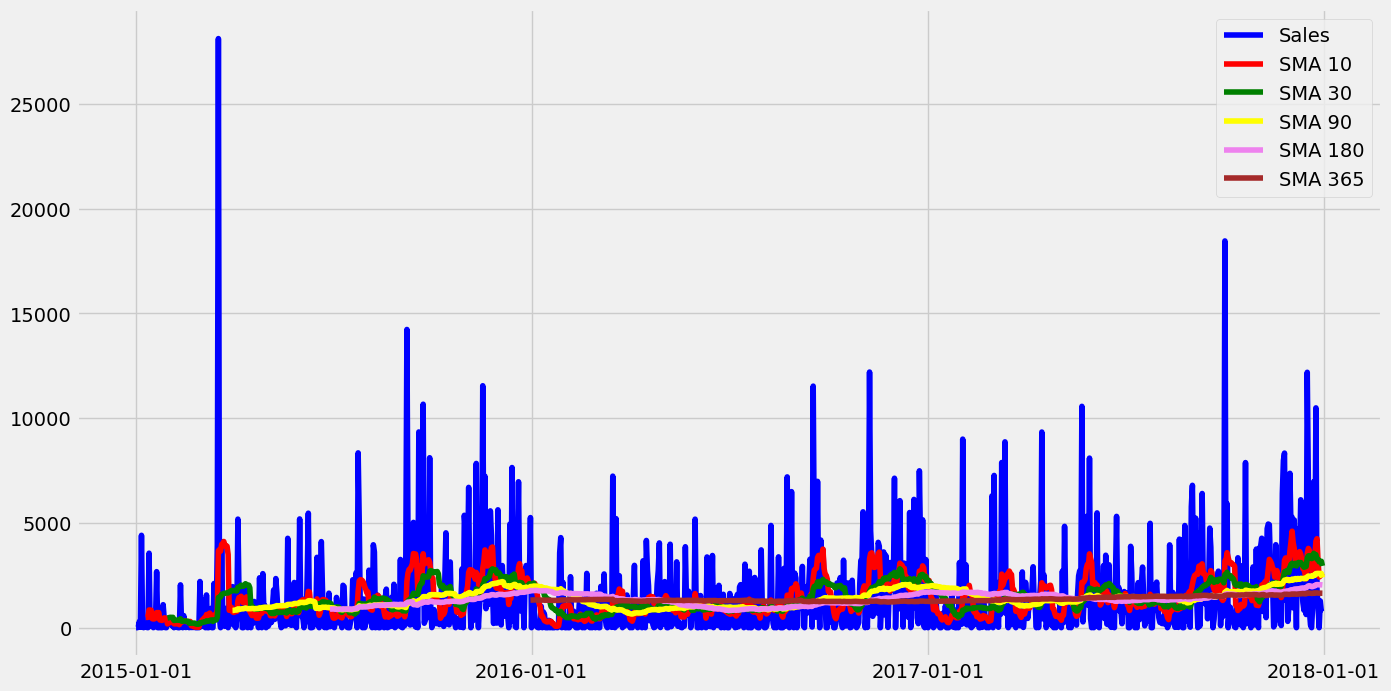

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [12]:
plt.figure(figsize=(15, 8))

plt.plot(df_sma['Order Date'], df_sma['Sales'], color='blue', label='Sales')
plt.plot(df_sma['Order Date'], df_sma['SMA 10'], color='red', label='SMA 10')
plt.plot(df_sma['Order Date'], df_sma['SMA 30'], color='green', label='SMA 30')
plt.plot(df_sma['Order Date'], df_sma['SMA 90'], color='yellow', label='SMA 90')
plt.plot(df_sma['Order Date'], df_sma['SMA 180'], color='violet', label='SMA 180')
plt.plot(df_sma['Order Date'], df_sma['SMA 365'], color='brown', label='SMA 365')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-01-01'))

plt.legend()
plt.show()
plt.figure(figsize=(15, 8))



### Forecast sales

In [13]:
# Forecasts for the period 2019-01-01 to 2019-01-31

print("10 Day SMA Forecast: ", sum(df_sma['SMA 10'].iloc[-365:]))
print("30 Day SMA Forecast: ", sum(df_sma['SMA 30'].iloc[-365:]))
print("90 Day SMA Forecast: ", sum(df_sma['SMA 90'].iloc[-365:]))
print("180 Day SMA Forecast: ", sum(df_sma['SMA 180'].iloc[-365:]))
print("365 Day SMA Forecast: ", sum(df_sma['SMA 365'].iloc[-365:]))

10 Day SMA Forecast:  602046.8523999997
30 Day SMA Forecast:  594637.1769000002
90 Day SMA Forecast:  579017.636383333
180 Day SMA Forecast:  563099.6047944445
365 Day SMA Forecast:  527259.0907484933


In [14]:
# RMSE 
print("10 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 10'].iloc[-365:])))
print("30 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])))
print("90 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 90'].iloc[-365:])))
print("180 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 180'].iloc[-365:])))
print("365 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 365'].iloc[-365:])))

10 Day SMA Error:  2399.5922310575315
30 Day SMA Error:  2336.1972034507453
90 Day SMA Error:  2363.6534031552483
180 Day SMA Error:  2392.658843698943
365 Day SMA Error:  2391.1377234814004


When forecasting a year, the best window for SMA forecast is 30 days. 

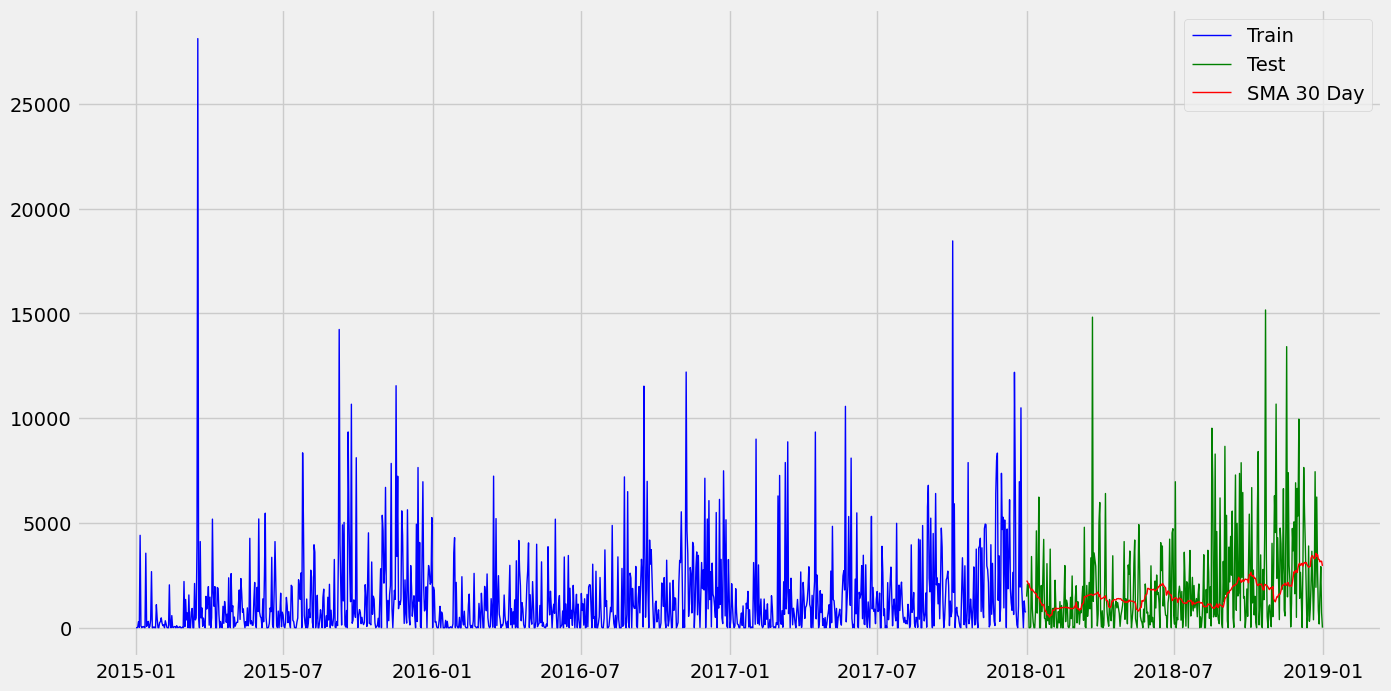

In [15]:
# Plot the SAM 30 Day forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], df_sma['SMA 30'].iloc[-365:], label='SMA 30 Day', color='red', linewidth=1)
plt.legend()
plt.show()

## Model 2 - ARIMA

In [16]:
# Format the data
df_arima_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_arima_train = df_arima_train.asfreq('D')

# Grid search to find the best parameters for ARIMA model
p = range(0, 4)  # Example: considering 0, 1, 2
d = range(0, 4)  # Example: considering 0, 1, 2
q = range(0, 4)  # Example: considering 0, 1, 2

pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(df_arima_train, order=param)
        results = model.fit()

        # Compare this model's AIC to the best (lowest) AIC found so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:  # Catch and ignore exceptions caused by unfit model specifications
        continue

print(f"Best ARIMA{best_pdq}\n\n Best AIC: {best_aic}")


c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Dinesh\anaconda3\envs\io

Best ARIMA(2, 1, 3)

 Best AIC: 19848.76160586895


### Forecast

In [17]:
arima = ARIMA(df_arima_train, order=best_pdq)
arima_fit = arima.fit()

forecast_arima = arima_fit.forecast(steps=365)
forecast_arima

c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2018-01-01    2666.057082
2018-01-02    3256.826464
2018-01-03    2529.629012
2018-01-04    2266.166344
2018-01-05    3108.275401
                 ...     
2018-12-27    2592.828144
2018-12-28    2978.103412
2018-12-29    2727.140534
2018-12-30    2455.529494
2018-12-31    2826.903189
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [18]:
# RMSE
error_arima = np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima))
print("ARIMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)))

ARIMA Error:  2438.8553796740607


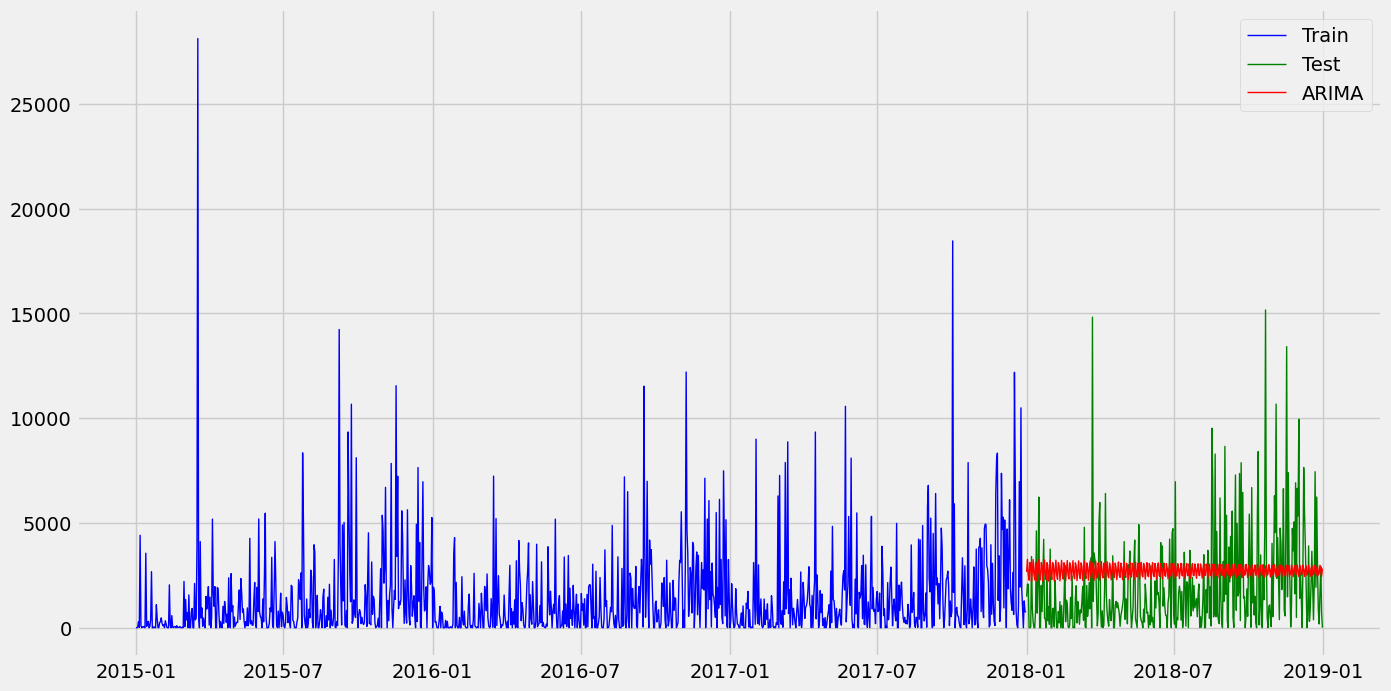

In [19]:
# Plot the ARIMA forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_arima, label='ARIMA', color='red', linewidth=1)
plt.legend()
plt.show()


### Check for seasonality 

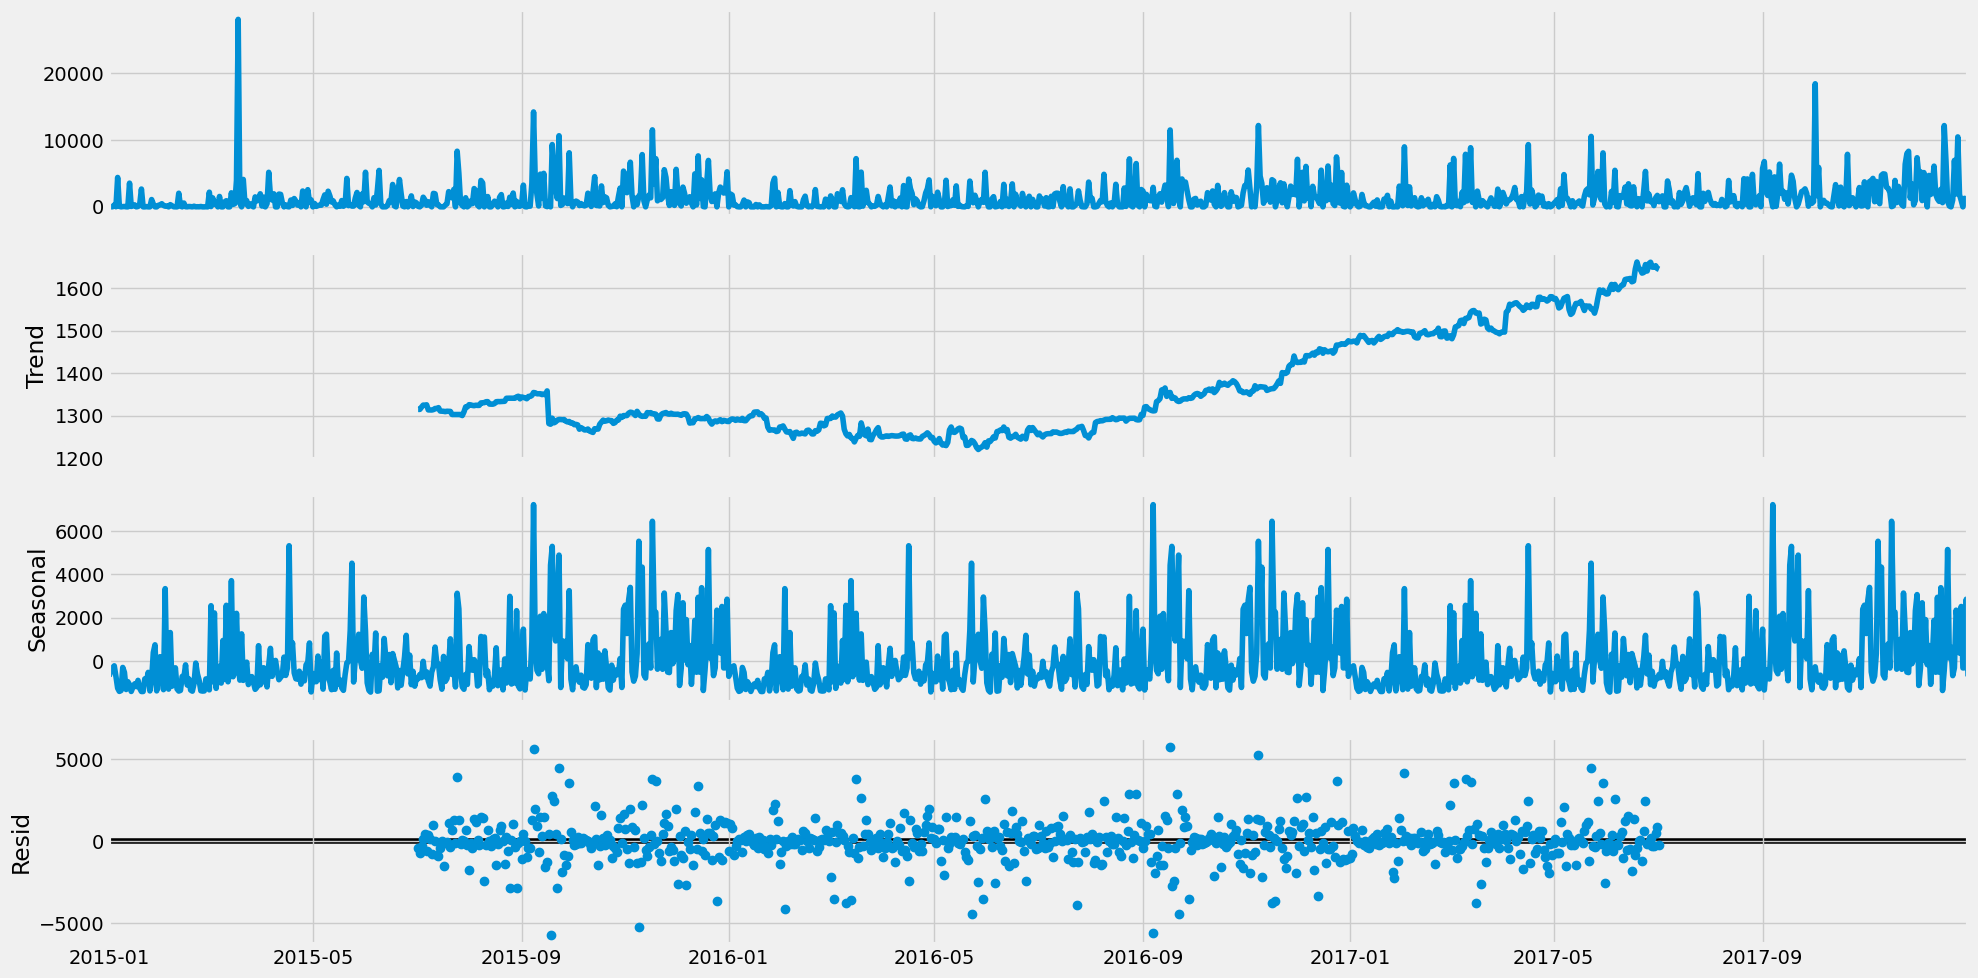

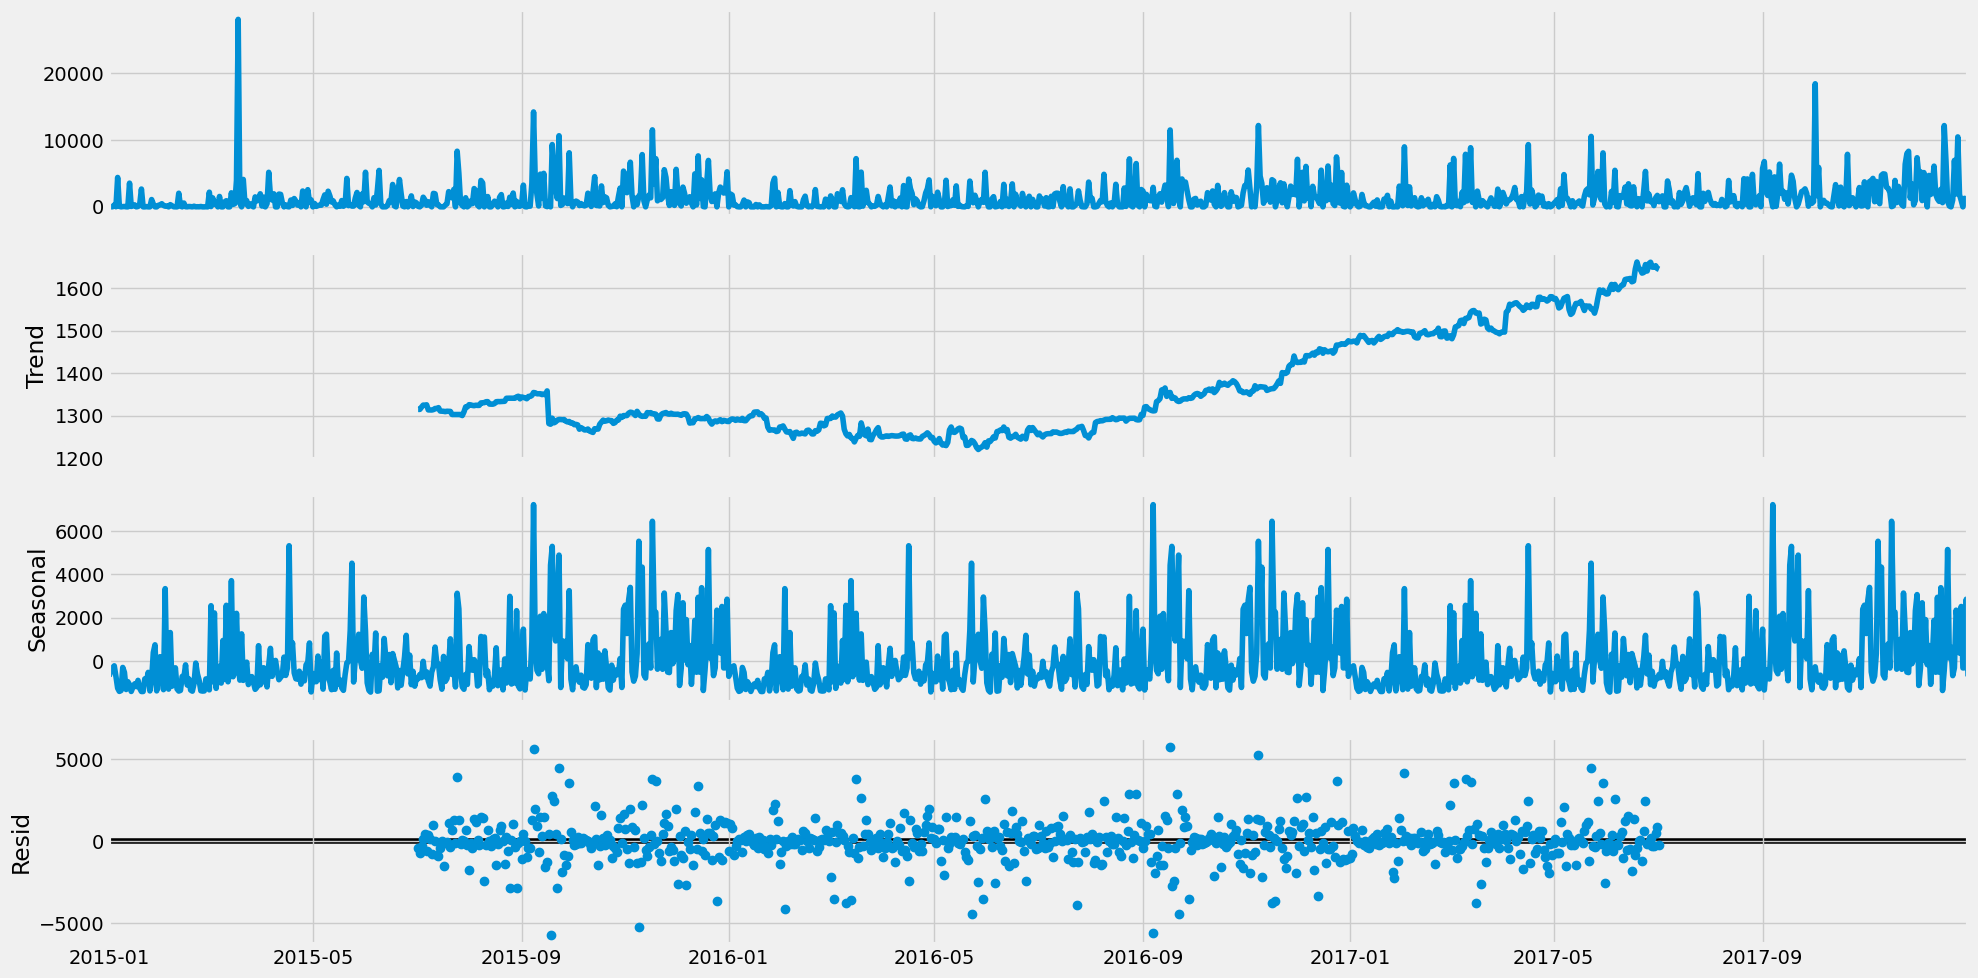

In [20]:
# Use statsmodels seasonal_decomp to check seasonality 
plt.rcParams['figure.figsize'] = [20, 10]

decomposition = seasonal_decompose(df_arima_train, model='additive', period=365)

decomposition.plot()

## SARIMA Daily

# Trying SARIMA with the daily data 

# Format the data
# df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_train = df_sm_train.resample('M').sum()
# df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_test = df_sm_test.resample('M').sum()

df_sm_daily_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_daily_test = df_test[['Order Date', 'Sales']].set_index('Order Date')

# Grid search to find the best parameters for SARIMA model
# p = range(0, 2)  # Example: considering 0, 1, 2
# d = range(0, 2)  # Example: considering 0, 1, 2
# q = range(0, 2)  # Example: considering 0, 1, 2

# P = range(0, 2)
# D = range(0, 2)
# Q = range(0, 2)
# S = [365]

# param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

# best_aic = np.inf
# best_params = None

# for params in param_combinations:
#     try:
#         sm = SARIMAX(df_sm_daily_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
#         results = sm.fit(disp=False)
        
#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_params = params
#     except:
#         continue

# print(f"Best AIC: {best_aic}")
# print(f"Best Parameters: {best_params}")

### Forecast

# SARIMA daily grid search is very slow, so taking params from ARIMA
inf_params = (2, 2, 2, 2, 2, 2, 365)

sm_daily = SARIMAX(df_sm_daily_train, order=inf_params[:3], seasonal_order=inf_params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_daily_fit = sm_daily.fit()

forecast_sarima_daily = sm_daily_fit.forecast(steps=30)
forecast_sarima_daily

# RMSE
error_sarima_daily = np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily))
print("SARIMA Daily Error: ", np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily)))

## Model 3 - SARIMA, monthly

# Because SARIMAX is slow to compute, we will group by month instead of day

# Format the data
df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_train = df_sm_train.resample('M').sum()
df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
df_sm_test = df_sm_test.resample('M').sum()

# Grid search to find the best parameters for SARIMA model
p = range(0, 3)  # Example: considering 0, 1, 2
d = range(0, 3)  # Example: considering 0, 1, 2
q = range(0, 3)  # Example: considering 0, 1, 2

P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
S = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

best_aic = np.inf
best_params = None

for params in param_combinations:
    try:
        sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        results = sm.fit(disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")




### Forecast

sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_fit = sm.fit()

forecast_sarima = sm_fit.forecast(steps=1)
forecast_sarima

# RMSE
error_sarima = np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima))
print("SARIMAX Error: ", np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)))

## Model 4 - Prophet model

In [21]:
#Format the training and test data for Prophet
df_pt_train = df_train[['Order Date', 'Sales']]
df_pt_train = df_pt_train.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

df_pt_test = df_test[['Order Date', 'Sales']]
df_pt_test = df_pt_test.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [22]:
# Instantiate the Prophet model
pt = Prophet()

pt_fit = pt.fit(df_pt_train)

15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing


### Forecast

In [23]:
future = pt_fit.make_future_dataframe(periods=365)

forecast_pt = pt_fit.predict(future)
forecast_pt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1246.546908,-1935.155011,3129.130522,1246.546908,1246.546908,-629.597310,-629.597310,-629.597310,-643.313261,-643.313261,-643.313261,13.715951,13.715951,13.715951,0.0,0.0,0.0,616.949598
1,2015-01-02,1246.667069,-2206.519058,2925.662650,1246.667069,1246.667069,-844.040402,-844.040402,-844.040402,-716.063467,-716.063467,-716.063467,-127.976935,-127.976935,-127.976935,0.0,0.0,0.0,402.626667
2,2015-01-03,1246.787230,-932.618805,3889.052507,1246.787230,1246.787230,103.653762,103.653762,103.653762,371.131161,371.131161,371.131161,-267.477399,-267.477399,-267.477399,0.0,0.0,0.0,1350.440992
3,2015-01-04,1246.907392,-1459.482308,3513.391152,1246.907392,1246.907392,-201.566900,-201.566900,-201.566900,201.062457,201.062457,201.062457,-402.629357,-402.629357,-402.629357,0.0,0.0,0.0,1045.340491
4,2015-01-05,1247.027553,-1565.852359,3220.631442,1247.027553,1247.027553,-480.987280,-480.987280,-480.987280,50.360794,50.360794,50.360794,-531.348074,-531.348074,-531.348074,0.0,0.0,0.0,766.040273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,2075.864966,-244.872163,4674.917486,2042.590542,2104.207170,37.608888,37.608888,37.608888,-643.313261,-643.313261,-643.313261,680.922149,680.922149,680.922149,0.0,0.0,0.0,2113.473853
1457,2018-12-28,2076.726033,-743.779461,4279.394338,2043.262419,2105.130172,-156.454528,-156.454528,-156.454528,-716.063467,-716.063467,-716.063467,559.608939,559.608939,559.608939,0.0,0.0,0.0,1920.271505
1458,2018-12-29,2077.587099,173.957290,5336.951980,2043.935250,2106.100042,801.507965,801.507965,801.507965,371.131161,371.131161,371.131161,430.376804,430.376804,430.376804,0.0,0.0,0.0,2879.095064
1459,2018-12-30,2078.448166,201.460204,5063.729667,2044.562679,2107.155002,496.063277,496.063277,496.063277,201.062457,201.062457,201.062457,295.000820,295.000820,295.000820,0.0,0.0,0.0,2574.511443


In [25]:
forecast_pt_sum = forecast_pt['yhat'].iloc[-365:].sum()

df_pt_test_sum = df_pt_test['y'].sum() 

diff = abs(forecast_pt_sum - df_pt_test_sum)

pt_error_pct = (diff / df_pt_test_sum) * 100
pt_error_pct

2.807444514913202

In [72]:
# RMSE
rmse_pt = np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:]))
print("Prophet Error: ", rmse_pt)

Prophet Error:  2245.2271576728267


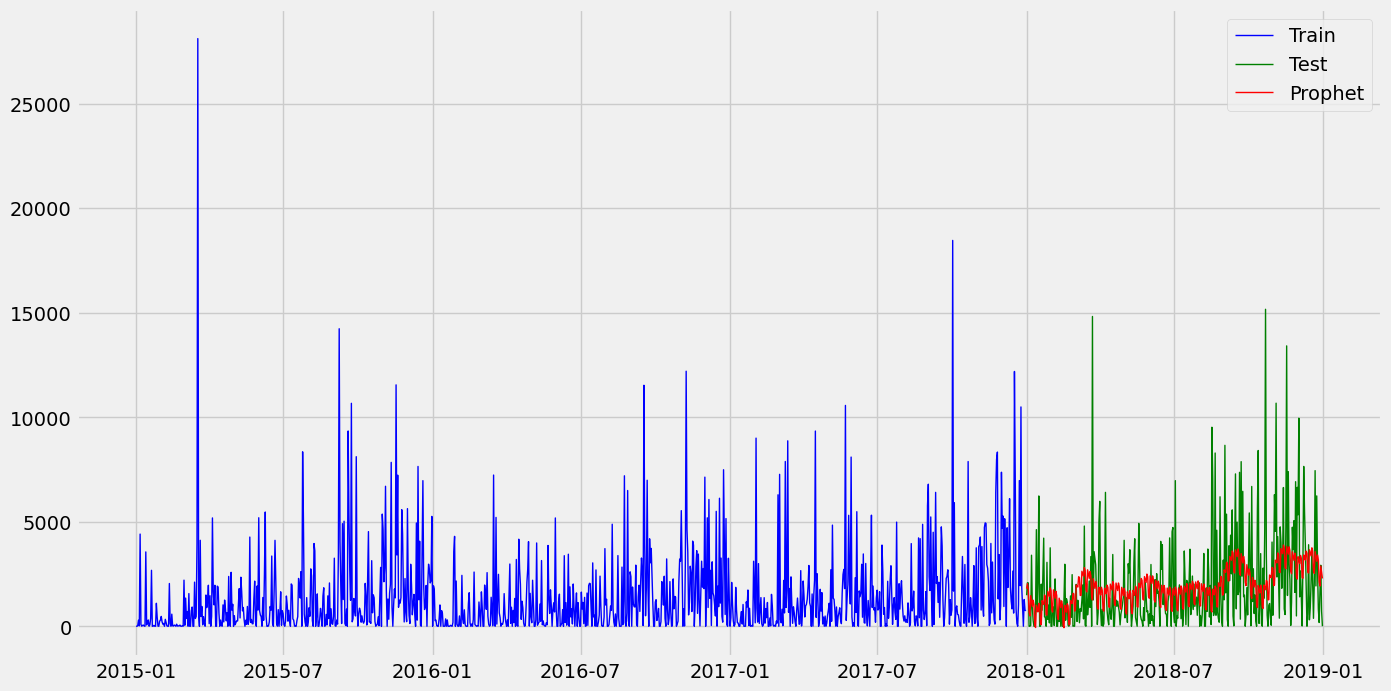

In [73]:
# Plot the Prophet forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_pt[-365:]['yhat'], label='Prophet', color='red', linewidth=1)
plt.legend()
plt.show()

## Model 5 - VAR

In [75]:
# We need to check if the categorical variables can be one hot encoded 
print(df['Category'].value_counts())
print("\n", df['Sub-Category'].value_counts())
print("\n", df['Region'].value_counts())
print("\n", df['Segment'].value_counts())

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

 Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

 Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

 Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64


In [76]:
# Select categorical variables and get dummies 
df_var = df[['Order Date', 'Sales', 'Category', 'Region', 'Segment']]
df_var.set_index('Order Date', inplace=True)
df_var_dum = pd.get_dummies(df_var, columns=['Category', 'Region', 'Segment'], drop_first=True, dtype=int)

In [77]:
df_var_dum.head()

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2017-11-08,261.9600,0,0,0,1,0,0,0
2017-11-08,731.9400,0,0,0,1,0,0,0
2017-06-12,14.6200,1,0,0,0,1,1,0
2016-10-11,957.5775,0,0,0,1,0,0,0
2016-10-11,22.3680,1,0,0,1,0,0,0


In [78]:
df_var_grp = df_var_dum.groupby('Order Date').agg({'Sales': 'sum', 'Category_Office Supplies': 'sum', 'Category_Technology': 'sum', 'Region_East': 'sum', 'Region_South': 'sum', 'Region_West': 'sum', 'Segment_Corporate': 'sum', 'Segment_Home Office': 'sum'}).reset_index()

In [79]:
df_var_grp

,Order Date,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
0,2015-01-03,16.4480,1,0,0,0,0,0,0
1,2015-01-04,288.0600,3,0,0,0,0,0,3
2,2015-01-05,19.5360,1,0,1,0,0,0,0
3,2015-01-06,4407.1000,6,2,0,8,1,1,7
4,2015-01-07,87.1580,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1225,2018-12-26,814.5940,4,0,1,0,0,2,1
1226,2018-12-27,177.6360,1,1,2,0,0,2,0
1227,2018-12-28,1657.3508,12,1,4,1,6,8,3
1228,2018-12-29,2915.5340,5,1,1,5,5,2,0


In [80]:
# Change Order Date to datetime
df_var_grp['Order Date'] = pd.to_datetime(df_var_grp['Order Date'])

# Check for missing days
is_one_day_apart = (df_var_grp['Order Date'].diff().dt.days == 1).all()
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [81]:
# Add the missing days with 0 values for all variables 
daily_index = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
df_var_daily = pd.DataFrame(index=daily_index)

# Now we merge the original DataFrame with the new DataFrame, filling missing values with 0
df_var_merged = df_var_daily.merge(df_var_grp, how='left', left_index=True, right_on='Order Date').fillna(0)


In [82]:
# Order the dataframes by 'Order Date'
df_var_merged = df_var_merged.sort_values(by='Order Date', ascending=True)

# Set the 'Order Date' column as the index
df_var_merged = df_var_merged.set_index('Order Date')

In [83]:
df_var_merged

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2015-01-01,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,16.4480,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,288.0600,3.0,0.0,0.0,0.0,0.0,0.0,3.0
2015-01-05,19.5360,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-12-27,177.6360,1.0,1.0,2.0,0.0,0.0,2.0,0.0
2018-12-28,1657.3508,12.0,1.0,4.0,1.0,6.0,8.0,3.0
2018-12-29,2915.5340,5.0,1.0,1.0,5.0,5.0,2.0,0.0


In [84]:
# Run ADF test for each variable to check for stationarity
for column in df_var_merged.columns:
    result = adfuller(df_var_merged[column])
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print("\n")

ADF Statistic for Sales: -4.942060643777004
p-value: 2.8863182713336527e-05
Critical Values: {'1%': -3.434899302257815, '5%': -2.8635492080466607, '10%': -2.567839687982253}


ADF Statistic for Category_Office Supplies: -4.531213025508765
p-value: 0.0001726212508424974
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Category_Technology: -4.783271330123432
p-value: 5.8538328348279265e-05
Critical Values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}


ADF Statistic for Region_East: -5.075490094505639
p-value: 1.5700269919873737e-05
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Region_South: -6.996857278118077
p-value: 7.49495323367439e-10
Critical Values: {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}


ADF Statistic for Region_West: -4.84694466983413
p-value: 4.418860119795582e-

In [85]:
# Split data into train and test 
df_var_train = df_var_merged[:-365]
df_var_test = df_var_merged[-365:]

In [86]:
print("Train: ", df_var_train.shape)
print("Test: ", df_var_test.shape)

Train:  (1096, 8)
Test:  (365, 8)


### Fitting the model

In [87]:
# Instantiate and fit the model
vm = VAR(df_var_train)
vm_results = vm.fit(maxlags=15, ic='aic')

print(vm_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Mar, 2024
Time:                     08:59:11
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    23.1952
Nobs:                     1095.00    HQIC:                   22.9909
Log likelihood:          -24877.3    FPE:                8.52715e+09
AIC:                      22.8665    Det(Omega_mle):     7.98664e+09
--------------------------------------------------------------------
Results for equation Sales
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                             977.108822        90.449141           10.803           0.000
L1.Sales                            0.021182         0.039579            0.535           0.593
L1.C

c:\Users\Dinesh\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Forecast

In [88]:
lag_order = vm_results.k_ar
forecasted_values = vm_results.forecast(df_var_merged.values[-lag_order:], steps=365)
forecasted_values

array([[9.77108822e+02, 2.76097649e+00, 8.00984588e-01, ...,
        1.41688007e+00, 1.36838696e+00, 7.89931873e-01],
       [1.30145614e+03, 3.38796587e+00, 1.02070466e+00, ...,
        1.76226696e+00, 1.69528195e+00, 9.47600853e-01],
       [1.38051060e+03, 3.54585917e+00, 1.07892397e+00, ...,
        1.85220283e+00, 1.78320941e+00, 9.88616870e-01],
       ...,
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00],
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00],
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00]])

In [89]:
# Convert forecasted_values to DataFrame for easy manipulation
forecasted_df = pd.DataFrame(forecasted_values, index=df_var_test.index, columns=df_var_test.columns)

# RMSE
rmse_var = np.sqrt(mean_squared_error(df_var_test['Sales'], forecasted_df['Sales']))
rmse_var

2426.802822477525

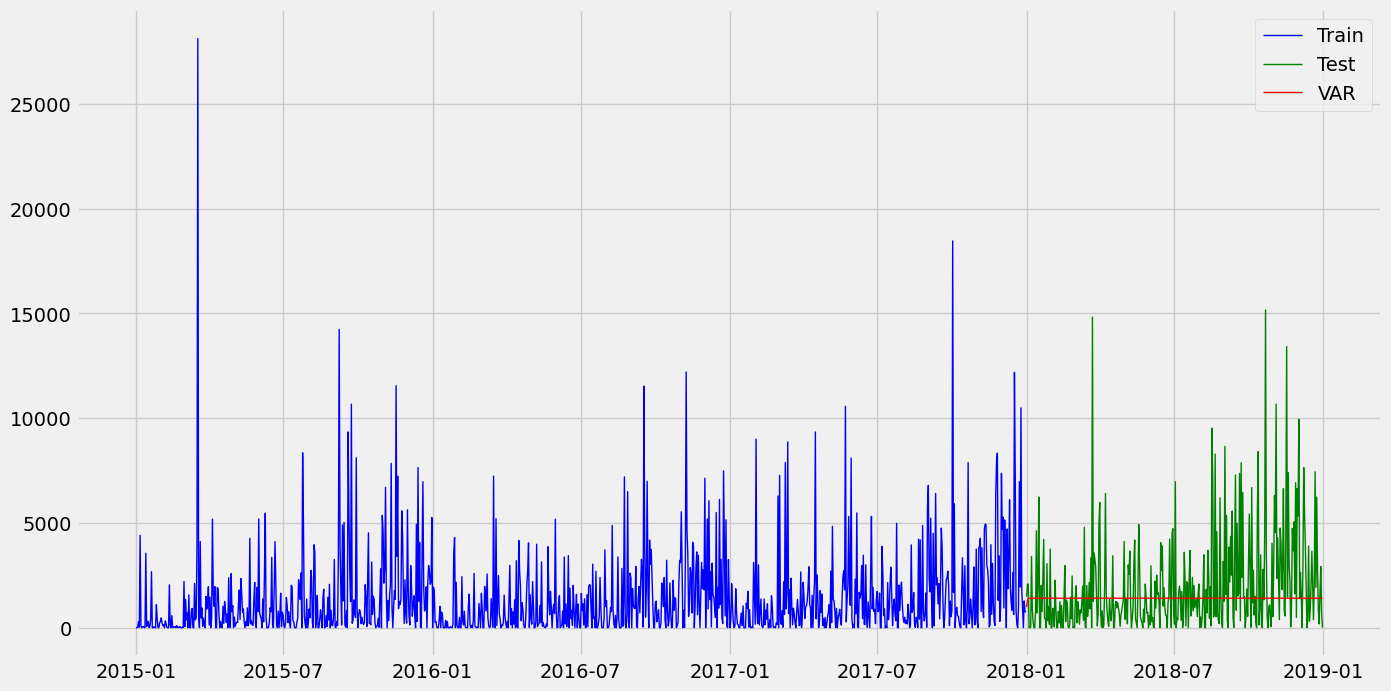

In [90]:
# Plot the VAR forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecasted_df['Sales'], label='VAR', color='red', linewidth=1)
plt.legend()
plt.show()

In [38]:
print((61506/df_test['Sales'].sum())*100)

74.07649282258933


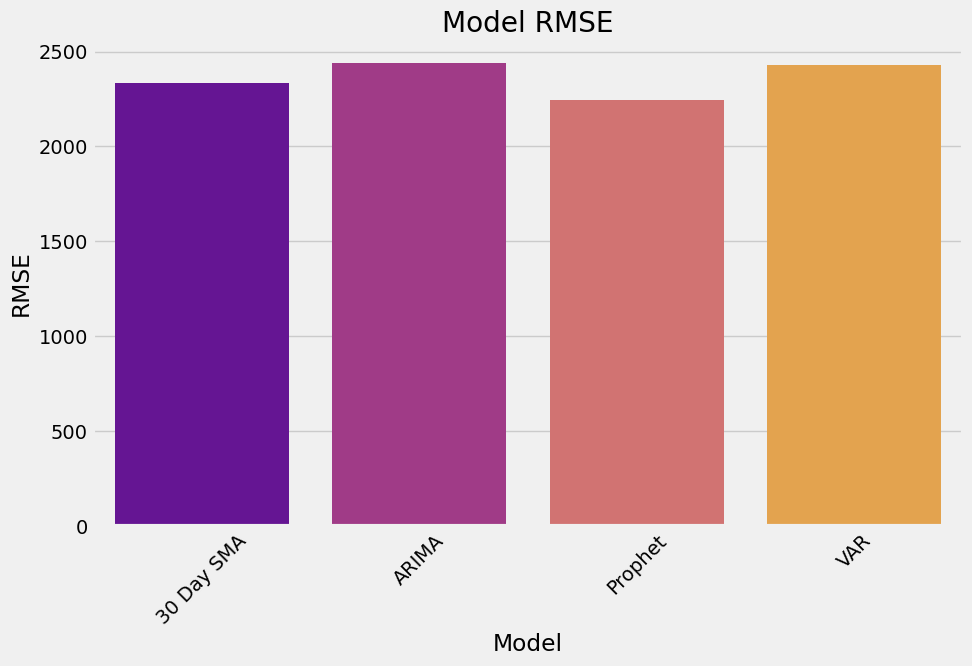

In [165]:
# Put all the errors into one dataframe 
df_errors = pd.DataFrame({
    'Model': ['30 Day SMA', 'ARIMA', 'Prophet', 'VAR'],
    'RMSE': [np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])), 
             np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)), 
            # np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)),
             rmse_pt, 
             rmse_var]
})

# Plot a bar chart of the errors with labels for each bar
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=df_errors, palette='plasma')
plt.title('Model RMSE')
plt.xticks(rotation=45)
plt.show()

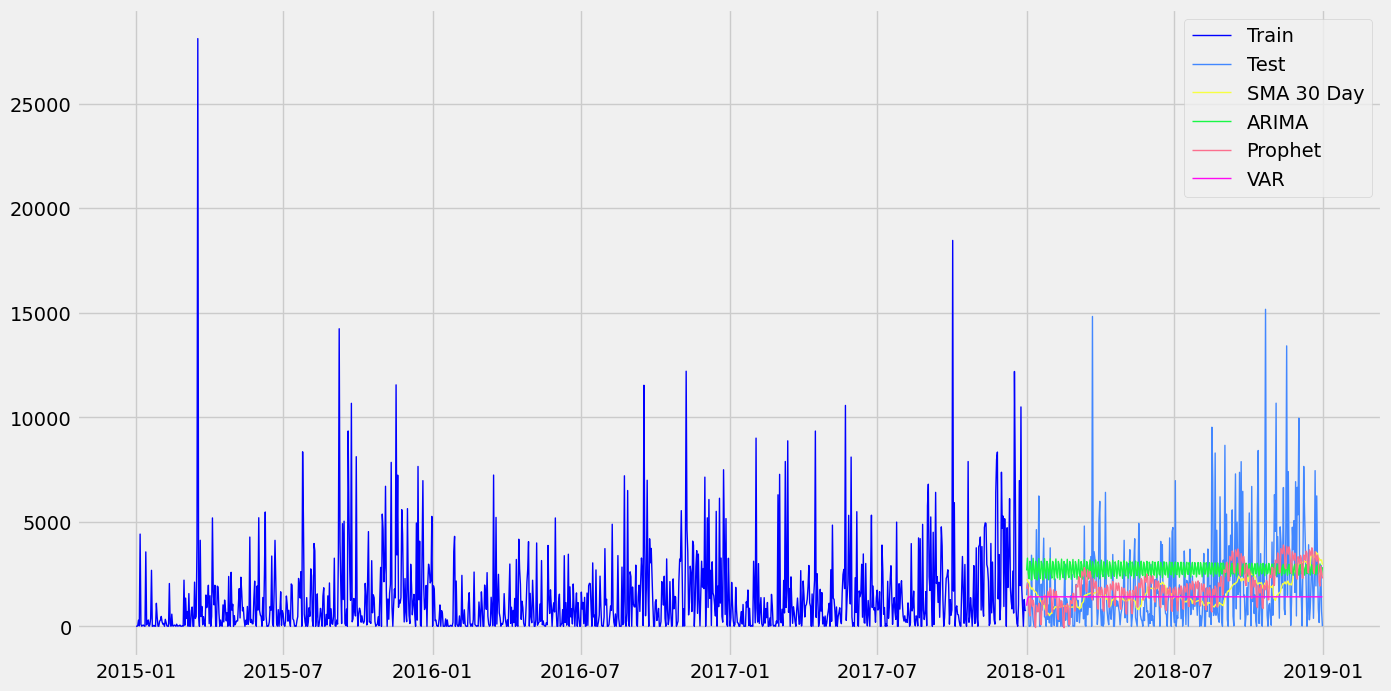

In [95]:
# Plot all the forecasts and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='#4287ff', linewidth=1)
plt.plot(df_test['Order Date'], df_sma['SMA 30'].iloc[-365:], label='SMA 30 Day', color='#f6ff42', linewidth=1)
plt.plot(df_test['Order Date'], forecast_arima, label='ARIMA', color='#19f745', linewidth=1)
plt.plot(df_test['Order Date'], forecast_pt[-365:]['yhat'], label='Prophet', color='#fc6f8e', linewidth=1)
plt.plot(df_test['Order Date'], forecasted_df['Sales'], label='VAR', color='#ff0af3', linewidth=1)
plt.legend()
plt.show()